# Word Embeddings: Coding the Word2Vec Algorithm

_Understanding the intuition behind word embedding creation with deep learning._

The word embeddings can be summarized in the following pipeline:
- Read the text
- Preprocess text
- Create (x, y) data points
- Create one hot encoded (x, y) matrices
- Train a neural network
- Extract the weights from the input layer

---
**_WORD EMBEDDING_** is the collective name for a set of language modeling and feature learnign techniques in natural language processing (NLP) where **words or phrases from the vocabulary are mapped to vectors of real numbers**.

---

The most important feature of word embeddings is that similar words in a semantic sense have a smaller distance (either Euclidean, cosine or other) between them than words that have no semantic relationship. Word embeddings are created using a neural network with...
- 1 input layer
- 1 hidden layer
- 1 output layer

In [84]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [65]:
# create the data
texts = pd.read_csv('./res/data/sample.csv')
texts = [x for x in texts['text']]

The computer does not understand that the words "king", "prince", and "man" are closer together in a semantic sense than the words "queen", "princess", and "daughter". All it sees are encoded characters to binary. In order for it to understand these semantics, we need to create X and Y matrices and fit it to a neural network.

When creating the training matrices for word embeddings, one of the hyperparameters is the **window size of the context (w)**. The minimum value for this is 1 because without context, the algorithm cannot work. Assuming that `w` = 2...


> **The** _future king_ is the prince.

The bolded word **the** is called the focus word and 2 words to the leff and 2 words to the right (`w` = 2) are the context words.

In [66]:
import re
import string as st
from  nltk.corpus import stopwords

In [67]:
def create_unique_word_dict(text:list) -> dict:
    '''
    A method that creates a dictionary where the keys are unique words.
    '''
    
    # getting all the unique wqords from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()
    
    # creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })
    
    return unique_word_dict

In [68]:
def clean_text(
    string: str,
    punctuations=st.punctuation,
    stop_words=stopwords.words('english')) -> str:
    '''
    A method to clean text.
    '''
    
    # cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)
    
    # cleaning the html elements
    string = re.sub(r'<.*?>', '', string)
    
    # removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, '')
    
    # converting the text to lower
    string = string.lower()
    
    # removing stop words
    string = ' '.join(word for word in string.split() if word not in stop_words)
    
    # cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()
    
    return string

The full pipeline to create the (X, Y) word pairs given a list of strings texts:

In [79]:
def text_preprocessing(
    text: list,
    punctuations=st.punctuation,
    stop_words=stopwords.words('english')) -> list:
    '''
    A method to preprocess text.
    '''
    
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, '')
    
    # removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)
    # print('1', text)
    
    # removing digits
    text = re.sub(r'[0-9]+', '', text)
    # print('2', text)
    
    # clearning the whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # print('3', text)
    
    # setting every word to lower
    text = text.lower()
    # print('4', text)
    
    # converting all our text to a list
    text = text.split(' ')
    # print('5', text)
    
    # dropping empty strings
    text = [x for x in text if x!='']
    # print('6', text)
    
    # dropping stop words
    text = [x for x in text if x not in stop_words]
    # print('7', text)
    
    return text
    

In [80]:
# defining the window for context
window = 2

# creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:
    # cleaning the text
    text = text_preprocessing(text)
    
    # appending to all text list
    all_text += text
    
    # creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # getting the context that is ahead by *window* words
            if (i + 1 + w) < len(text):
                word_lists.append([word] + [text[(i + 1 + w)]])
            # getting the context that is behind by *window* words
            if (i - w - 1) >= 0:
                word_lists.append([word] +  [text[(i - w - 1)]])
                
unique_word_dict = create_unique_word_dict(all_text)

In [85]:
# defining the number of features (unique words)
n_words = len(unique_word_dict)

# getting all the unique words
words = list(unique_word_dict.keys())

# creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    
    # creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)
    
    # one hot encoding the main word
    X_row[main_word_index] = 1
    
    # one hot encoding the main word
    Y_row[context_word_index] = 1
    
    # appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)
    
# converting the matrices into an array
X = np.asarray(X)
Y = np.asarray(Y)

56it [00:00, 80937.64it/s]


We now have X and Y matrices built from the focus word and context word pairs. The next step is to choose the embedding dimension. I will choose the dimension to be equal to 2 in order to later plot the words and see whether similar words form clusters.

![network](./res/layer_map.png)

The hidden layer dimension is the size of our word embedding. The output layers activation function is **softmax**. The activation function of the hidden layer is **linear**.

The input dimension is equal to the total number of unique words (remember, our X matrix is of the dimension n x 21). Each input node will have two weights connecting it to the hidden layer. These weights are the word embeddings! After the training of the network, we extract these weights and remove all the rest. We do not necessarily care about the output.

In [89]:
from keras.models import Input, Model
from keras.layers import Dense

# defining the size of the embedding
embed_size = 2

# defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics='accuracy')

# optimizing the network weights
model.fit(
    x=X,
    y=Y,
    batch_size=256,
    epochs=1000
)

# obtaining the weights from the neural network
# these are the so called word embeddings

# the input layer
weights = model.get_weights()[0]

# creating a dictionary to store the embeddings in
# the key is a unique word and the value is the numeric vector
embedding_dict = {}
for word in words:
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
    })

Epoch 1/1000
1/1 [==============================] - 0s 112ms/step - loss: 2.8544 - accuracy: 0.0536
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.8533 - accuracy: 0.0536
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.8522 - accuracy: 0.0536
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.8511 - accuracy: 0.0536
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.8500 - accuracy: 0.0536
Epoch 6/1000
1/1 [==============================] - 0s 732us/step - loss: 2.8489 - accuracy: 0.0536
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.8478 - accuracy: 0.0536
Epoch 8/1000
1/1 [==============================] - 0s 900us/step - loss: 2.8467 - accuracy: 0.0536
Epoch 9/1000
1/1 [==============================] - 0s 832us/step - loss: 2.8456 - accuracy: 0.0536
Epoch 10/1000
1/1 [==============================] - 0s 828us/step - loss: 2.8445 - accuracy: 0.0536
Epoch 11/

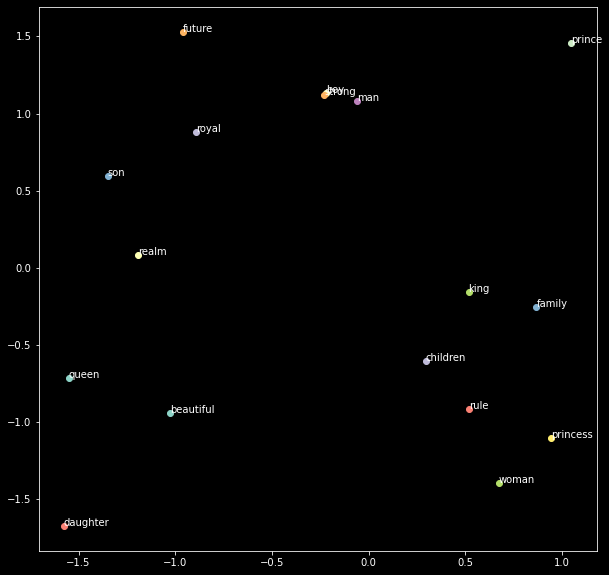

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))